(857, 222)
count    857.000000
mean      -0.011802
std        0.050134
min       -0.391545
25%       -0.032807
50%       -0.016667
75%       -0.002801
max        0.271957
dtype: float64
0.46222998016331934


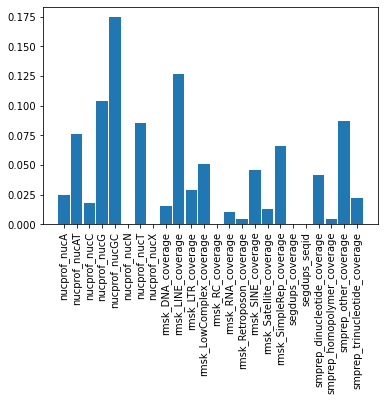

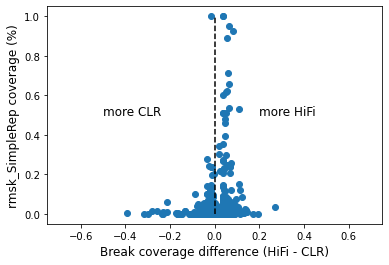

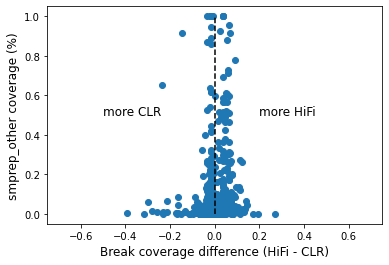

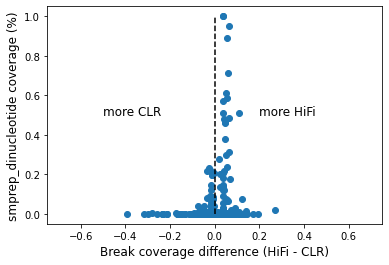

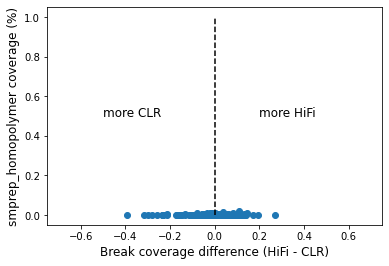

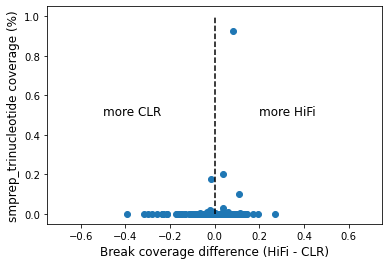

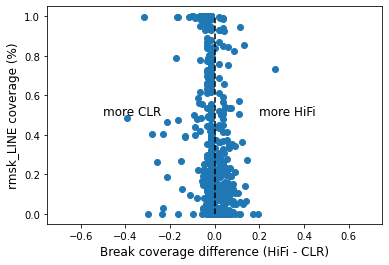

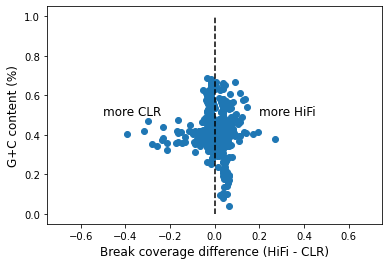

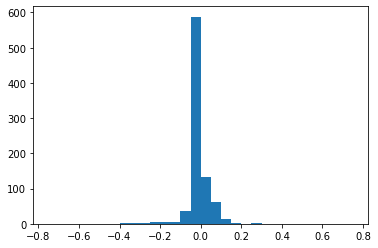

In [16]:
import io
import os
import pickle as pck

import pandas as pd
import sklearn as skl
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

folder = '/home/local/work/pipeline/run_folder/output/evaluation/break_analysis/tables'

grch38 = 'GRCh38_HGSVC2_noalt.H64.break.h5'
t2t = 'T2Tv1_38p13Y_chm13.H64.break.h5'

ref_assm = 'GRCh38'

dataset = os.path.join(folder, grch38)

metadata_file = dataset.replace('.h5', '.train.pck')
feat_file = dataset.replace('.h5', '.feat.h5')
debug = False

def compute_target_score(df):
    
    avg_cov_hifi = df.xs(
        ['HiFi', 'pct', 'coverage'],
        axis=1,
        level=['platform', 'unit', 'statistic']).mean(axis=1)
    
    avg_cov_clr = df.xs(
        ['CLR', 'pct', 'coverage'],
        axis=1,
        level=['platform', 'unit', 'statistic']).mean(axis=1)
    
    target_score = avg_cov_hifi - avg_cov_clr
    return target_score
    

df = pd.read_hdf(dataset, 'annotation')
df = df.loc[df[(ref_assm, 'REF', 0, 'nucprof', 'bp', 'length')] > 999, :].copy()
df = df.loc[df[(ref_assm, 'REF', 0, 'nucprof', 'bp', 'nucN')] == 0, :].copy()
df = df.loc[df[(ref_assm, 'REF', 0, 'segdups', 'bp', 'coverage')] == 0, :].copy()
print(df.shape)

target_score = compute_target_score(df)
features = df.xs(['REF', 'pct'], level=['platform', 'unit'], axis=1)

params = {}

if debug:
    params = {
        'loss': ['huber'],
        'learning_rate': [0.1],
        'n_estimators': [25],
        'subsample': [0.75],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'max_depth': [2],
        'min_impurity_decrease': [0.01],
        'max_features': ['sqrt'],
        'validation_fraction': [0.1],
        'n_iter_no_change': [5],
    }

else:
    params = {
        'loss': ['huber'],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 75, 100],
        'subsample': [0.5, 0.7, 0.9],
        'min_samples_split': [2, 4, 8],
        'min_samples_leaf': [1, 2],
        'max_depth': [1, 2, 4, 8, 16],
        'min_impurity_decrease': [0.],
        'max_features': ['sqrt'],
        'validation_fraction': [0.1],
        'n_iter_no_change': [5],
    }


if not os.path.isfile(feat_file):
    
    grid_search = GridSearchCV(
        GradientBoostingRegressor(),
        scoring='r2',
        param_grid=params,
        n_jobs=-1,
        cv=5,
        refit=True,
        return_train_score=True
    )
    
    fit_results = grid_search.fit(features, target_score)
    model = fit_results.best_estimator_
    hyperparams = fit_results.best_params_
    print(hyperparams)
    train_score = fit_results.best_score_
    print(train_score)
    ft_imp = model.feature_importances_

    feat_imp = []
    feat_index = []

    for n, i in zip(features.columns, ft_imp):
        ref, _, category, stat = n
        feat_imp.append(i)
        feat_index.append((ref, category, stat))

    feat_index = pd.MultiIndex.from_tuples(feat_index, names=['ref', 'category', 'statistic'])
    df_feat = pd.DataFrame(feat_imp, index=feat_index, columns=['feat_importance'])

    if not debug:
        metadata = {
            'hyperparams': hyperparams,
            'train_score': train_score,
            'fit_results': fit_results,
            'model': model
        }
        with open(metadata_file, 'wb') as dump:
            pck.dump(metadata, dump)

        with pd.HDFStore(feat_file, 'w') as hdf:
            hdf.put('importances', df_feat, format='fixed')
            hdf.put('features', features, format='fixed')
            hdf.put('scores', target_score, format='fixed')


with pd.HDFStore(feat_file, 'r') as hdf:
    df_imp = hdf['importances']
    df_feat = hdf['features']
    df_score = hdf['scores']

    
fig, ax = plt.subplots()

ax.bar(
    range(1, df_imp.shape[0]+1),
    df_imp['feat_importance'],
    width=0.9,
)
_ = ax.set_xticks(range(1, df_imp.shape[0]+1))
_ = ax.set_xticklabels(['{}_{}'.format(b, c) for a, b, c in df_imp.index], rotation=90)


rep_categories = [
    'rmsk_SimpleRep',
    'smprep_other',
    'smprep_dinucleotide',
    'smprep_homopolymer',
    'smprep_trinucleotide',
    'rmsk_LINE',
]

for rep_category in rep_categories:
    
    fig, ax = plt.subplots()

    ax.scatter(
        df_score,
        df_feat[(ref_assm, 0, rep_category, 'coverage')]
    )
    ax.set_xlim(-0.75, 0.75)
    ax.set_ylabel('{} coverage (%)'.format(rep_category), fontsize=12)
    ax.set_xlabel('Break coverage difference (HiFi - CLR)', fontsize=12)
    ax.vlines(0, 0, 1, ls='dashed')
    ax.text(0.2, 0.5, 'more HiFi', fontdict={'size': 12})
    ax.text(-0.5, 0.5, 'more CLR', fontdict={'size': 12})


fig, ax = plt.subplots()

ax.scatter(
    df_score,
    df_feat[(ref_assm, 0, 'nucprof', 'nucGC')]
)
ax.set_xlim(-0.75, 0.75)
ax.set_ylabel('G+C content (%)'.format(rep_category), fontsize=12)
ax.set_xlabel('Break coverage difference (HiFi - CLR)', fontsize=12)
ax.vlines(0, 0, 1, ls='dashed')
ax.text(0.2, 0.5, 'more HiFi', fontdict={'size': 12})
ax.text(-0.5, 0.5, 'more CLR', fontdict={'size': 12})    


fig, ax = plt.subplots()

_ = ax.hist(
    df_score,
    bins=np.arange(-0.75, 0.8, 0.05),
    density=False,
    histtype='stepfilled'
)
